# Problem Statement

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

 

The company markets its courses on several websites and search engines like Google. Once these people land on the website, they might browse the courses or fill up a form for the course or watch some videos. When these people fill up a form providing their email address or phone number, they are classified to be a lead. Moreover, the company also gets leads through past referrals. Once these leads are acquired, employees from the sales team start making calls, writing emails, etc. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

 

Now, although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’. If they successfully identify this set of leads, the lead conversion rate should go up as the sales team will now be focusing more on communicating with the potential leads rather than making calls to everyone. A typical lead conversion process can be represented using the following funnel:

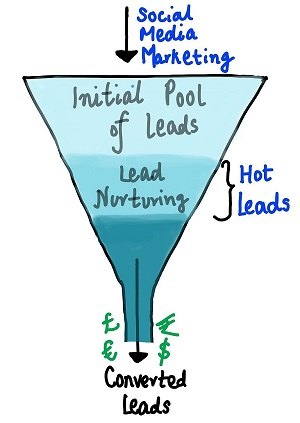

As you can see, there are a lot of leads generated in the initial stage (top) but only a few of them come out as paying customers from the bottom. In the middle stage, you need to nurture the potential leads well (i.e. educating the leads about the product, constantly communicating etc. ) in order to get a higher lead conversion.

 

X Education has appointed you to help them select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with a higher lead score have a higher conversion chance and the customers with a lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

### Data

You have been provided with a leads dataset from the past with around 9000 data points. This dataset consists of various attributes such as Lead Source, Total Time Spent on Website, Total Visits, Last Activity, etc. which may or may not be useful in ultimately deciding whether a lead will be converted or not. The target variable, in this case, is the column ‘Converted’ which tells whether a past lead was converted or not wherein 1 means it was converted and 0 means it wasn’t converted. You can learn more about the dataset from the data dictionary provided in the zip folder at the end of the page. Another thing that you also need to check out are the levels present in the categorical variables. Many of the categorical variables have a level called 'Select' which needs to be handled because it is as good as a null value (think why?).

## Goals of the case study

There are quite a few goals for this case study:

Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

# Solution

In [646]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import sklearn
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

## Common Functions to be used in the solutions

1. **get_dt_graph:** This will create and plot graphs for the solutions
2. **evaluate_model:** This will evaluate the models against for Accuracy and Confusion Matrix
3. **draw_roc:** This function generates and displays the Receiver Operating Characteristic (ROC) curve for a given set of actual labels and predicted probabilities. It calculates the false positive rate (FPR) and true positive rate (TPR) at various threshold settings, computes the Area Under the ROC Curve (AUC), and plots the ROC curve along with the AUC score. The function includes a diagonal reference line representing random guessing. The plot is displayed with labeled axes and a legend indicating the AUC score.

In [647]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [648]:
def get_dt_graph(dt_classifier, columns, class_names):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=columns, 
                    class_names=class_names)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [649]:
def evaluate_model(dt_classifier, y_train, X_train, y_test, X_test):
    print("Train Accuracy :", accuracy_score(y_train, dt_classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, dt_classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, dt_classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

In [650]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

## 1. Reading & understanding the dataset

In [651]:
leads = pd.read_csv('Leads.csv')
leads.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [652]:
leads.shape

(9240, 37)

In [653]:
leads.describe()

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     7.000000   
25%                1.000000                    14.000000   
50%                2.000000                    14.000000   
75%                3.000000                    15.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 5022.000000  
mean                    16.344883  
std                      1.811395  
min                     11.000000  
25%                     15.000000  
50%                     16.000000  
75%                     18.000000  
max                     20.000000

In [654]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

##  2. Data Cleaning 
### -Formating the data as required to process them.
1. Removing the rownumbers.
2. Treating null values.
3. Dropping unnecessary columns for analysis. 


Removing Index columns
Check if any duplicate values are present in the index columns here. If present It has to be treated, else they can be dropped as it is not relavent for data analysis.
The first two columns 'Prospect ID' and 'Lead Number' are the two index columns in this dataset.

In [655]:
sum(leads.duplicated(subset = 'Prospect ID')) == 0
sum(leads.duplicated(subset = 'Lead Number')) == 0

True

Since there are no duplicate values, we remove these columns from the dataframe.

In [656]:
#dropping indexes
leads.drop(['Prospect ID', 'Lead Number'], axis=1, inplace = True)

In [657]:
# Replacing the select variable with NaN
leads = leads.replace('Select', np.nan)

In [658]:
leads.isnull().sum()

Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                          2461
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

In [659]:
leads.index

RangeIndex(start=0, stop=9240, step=1)

### Handling Null Values

In [660]:
#check the percentage of nulls
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

In [661]:
# drop columns with 40% or more null values.
colum=leads.columns

for i in colum:
    if((100*(leads[i].isnull().sum()/len(leads.index))) >= 40):
        leads.drop(i, axis = 1, inplace = True)

In [662]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [663]:
# Analysing the value_count of City column as it has the highest amount of nulls, after dropping columns having 40% or above null values.
leads['City'].value_counts(dropna=False)

City
NaN                            3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64

Since most of the values are generated from the city 'Mumbai' we replace the null values also with 'Mumbai'.

In [664]:
leads['City'] = leads['City'].replace(np.nan,'Mumbai')

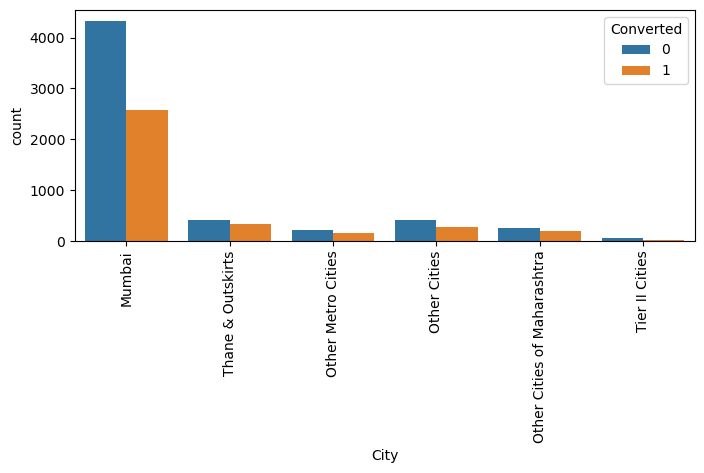

In [665]:
plt.figure(figsize=(8,3))
spr=sns.countplot(x=leads.City, hue=leads.Converted)
spr.set_xticklabels(spr.get_xticklabels(),rotation=90)
plt.show()

In [666]:
#Treating the next highest null Values 'Specialization'
leads['Specialization'].value_counts(dropna=False)

Specialization
NaN                                  3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: count, dtype: int64

In [667]:
#Since NaN has max values, we replace it as a category to consider it while calculating conversion rate.
leads['Specialization'] = leads['Specialization'].replace(np.nan, 'None')

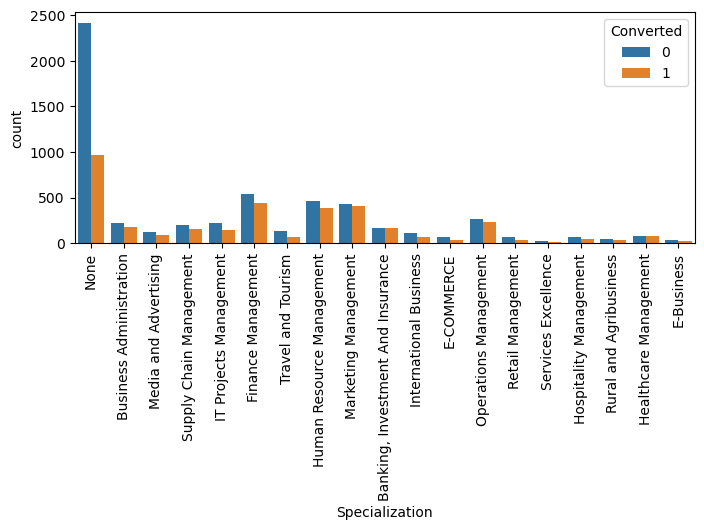

In [668]:

plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Specialization, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

A few of these categories are actually sub-caterogy of management stream, hence replacing all of it by 'Management_Specialization'.

In [669]:
#Management_Specialization
leads['Specialization'] = leads['Specialization'].replace(['Finance Management','Human Resource Management',
                                                           'Marketing Management','Operations Management',
                                                           'IT Projects Management','Supply Chain Management',
                                                    'Healthcare Management','Hospitality Management',
                                                           'Retail Management'] ,'Management_Specializations')  

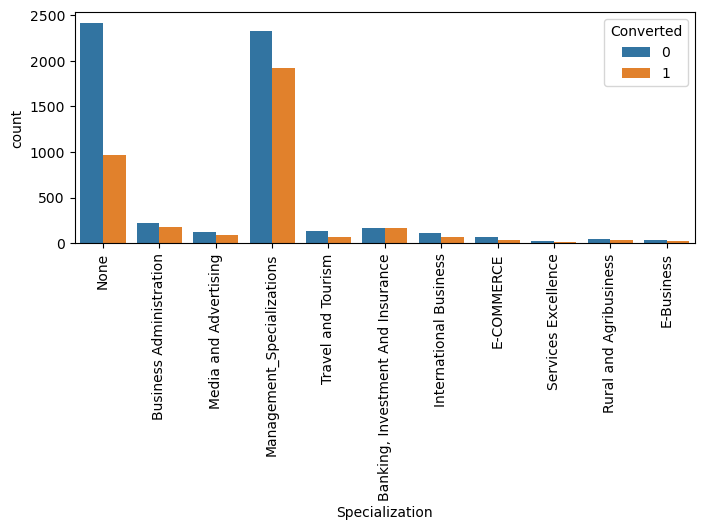

In [670]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Specialization, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [671]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [672]:
leads['Tags'].value_counts(dropna=False)

Tags
NaN                                                  3353
Will revert after reading the email                  2072
Ringing                                              1203
Interested in other courses                           513
Already a student                                     465
Closed by Horizzon                                    358
switched off                                          240
Busy                                                  186
Lost to EINS                                          175
Not doing further education                           145
Interested  in full time MBA                          117
Graduation in progress                                111
invalid number                                         83
Diploma holder (Not Eligible)                          63
wrong number given                                     47
opp hangup                                             33
number not provided                                    27
in touch 

In [673]:
leads['Tags'] = leads['Tags'].replace(np.nan,'None')

In [674]:
leads['Tags'] = leads['Tags'].replace(['In confusion whether part time or DLP', 'in touch with EINS','Diploma holder (Not Eligible)',
                                     'Approached upfront','Graduation in progress','number not provided', 'opp hangup','Still Thinking',
                                    'Lost to Others','Shall take in the next coming month','Lateral student','Interested in Next batch',
                                    'Recognition issue (DEC approval)','Want to take admission but has financial problems',
                                    'University not recognized','switched off','Already a student','Not doing further education','invalid number',
                                    'wrong number given','Interested  in full time MBA'], 'Other_Tags')


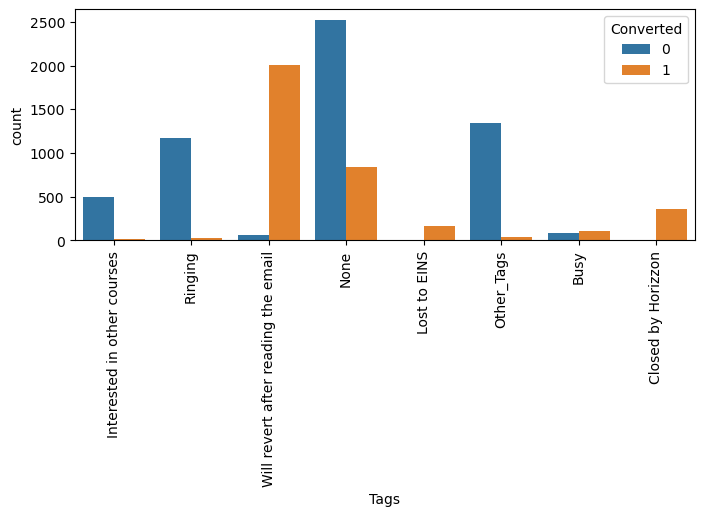

In [675]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Tags'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [676]:
#next highest null values
leads['What is your current occupation'].value_counts(dropna=False)

What is your current occupation
Unemployed              5600
NaN                     2690
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: count, dtype: int64

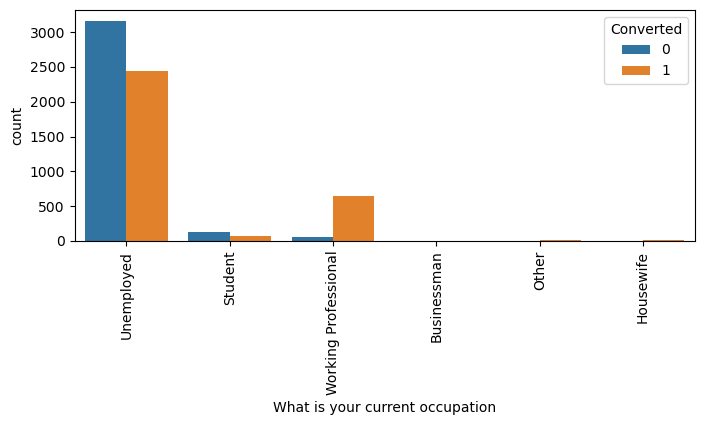

In [677]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What is your current occupation'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [678]:
leads['What is your current occupation'] = leads['What is your current occupation'].replace(np.nan, 'Unemployed')

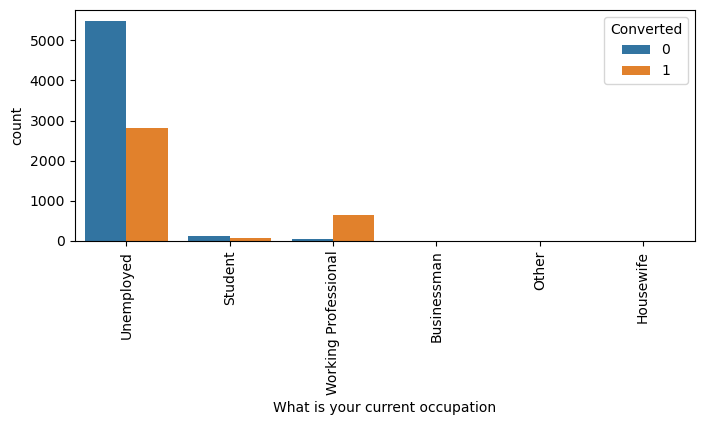

In [679]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What is your current occupation'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [680]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      6528
NaN                          2709
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [681]:
leads['What matters most to you in choosing a course'] = leads['What matters most to you in choosing a course'].replace(np.nan,'Better Career Prospects')

In [682]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

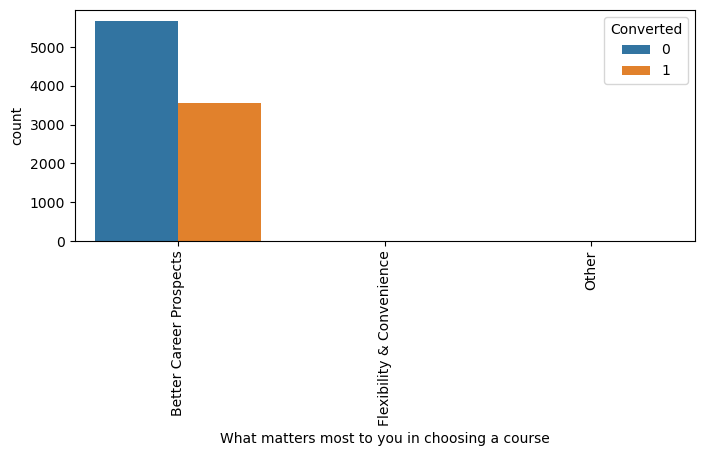

In [683]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['What matters most to you in choosing a course'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [684]:
leads['What matters most to you in choosing a course'].value_counts(dropna=False)

What matters most to you in choosing a course
Better Career Prospects      9237
Flexibility & Convenience       2
Other                           1
Name: count, dtype: int64

In [685]:
cols_to_drop=['What matters most to you in choosing a course']

Checking if all nulls have been treated appropriately

In [686]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [687]:
leads['Country'].value_counts(dropna=False)

Country
India                   6492
NaN                     2461
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Bahrain                    7
Hong Kong                  7
Oman                       6
France                     6
unknown                    5
Kuwait                     4
South Africa               4
Canada                     4
Nigeria                    4
Germany                    4
Sweden                     3
Philippines                2
Uganda                     2
Italy                      2
Bangladesh                 2
Netherlands                2
Asia/Pacific Region        2
China                      2
Belgium                    2
Ghana                      2
Kenya                      1
Sri Lanka                  1
Tanzania                   1
Malaysia                   1
Liberia                    1
Switze

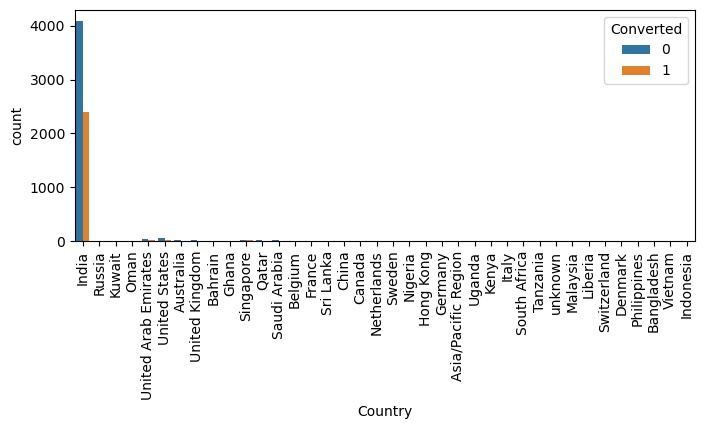

In [688]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads.Country, hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [689]:
cols_to_drop.append('Country')
cols_to_drop

['What matters most to you in choosing a course', 'Country']

In [690]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [691]:
leads['Lead Source'].value_counts(dropna=False)

Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
NaN                    36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: count, dtype: int64

In [692]:
leads['Lead Source'] = leads['Lead Source'].replace(np.nan,'Others')
leads['Lead Source'] = leads['Lead Source'].replace('google','Google')
leads['Lead Source'] = leads['Lead Source'].replace('Facebook','Social Media')
leads['Lead Source'] = leads['Lead Source'].replace(['bing','Click2call','Press_Release',
                                                     'youtubechannel','welearnblog_Home',
                                                     'WeLearn','blog','Pay per Click Ads',
                                                    'testone','NC_EDM'] ,'Others')

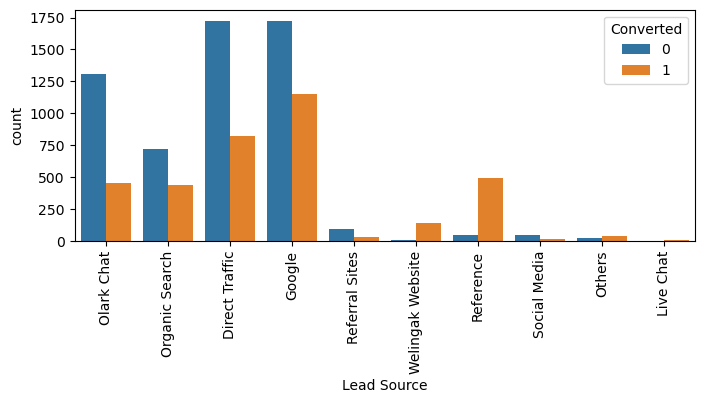

In [693]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Lead Source'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

In [694]:
leads['Last Activity'].value_counts(dropna=False)

Last Activity
Email Opened                    3437
SMS Sent                        2745
Olark Chat Conversation          973
Page Visited on Website          640
Converted to Lead                428
Email Bounced                    326
Email Link Clicked               267
Form Submitted on Website        116
NaN                              103
Unreachable                       93
Unsubscribed                      61
Had a Phone Conversation          30
Approached upfront                 9
View in browser link Clicked       6
Email Received                     2
Email Marked Spam                  2
Visited Booth in Tradeshow         1
Resubscribed to emails             1
Name: count, dtype: int64

In [695]:
leads['Last Activity'] = leads['Last Activity'].replace(np.nan,'Others')
leads['Last Activity'] = leads['Last Activity'].replace(['Unreachable','Unsubscribed',
                                                        'Had a Phone Conversation', 
                                                        'Approached upfront',
                                                        'View in browser link Clicked',       
                                                        'Email Marked Spam',                  
                                                        'Email Received','Resubscribed to emails',
                                                         'Visited Booth in Tradeshow'],'Others')

In [696]:
leads['Last Activity'].value_counts(dropna=False)

Last Activity
Email Opened                 3437
SMS Sent                     2745
Olark Chat Conversation       973
Page Visited on Website       640
Converted to Lead             428
Email Bounced                 326
Others                        308
Email Link Clicked            267
Form Submitted on Website     116
Name: count, dtype: int64

In [697]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.00
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     0.00
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

In [698]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Lead Origin                                       0.00
Lead Source                                       0.00
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     0.00
Country                                          26.63
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper                                         0.00
Digital Ad

All the values are now non-zero. Now that all the nulls are treated, we compare the variables.

In [699]:
leads['Lead Origin'].value_counts(dropna=False)

Lead Origin
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: count, dtype: int64

# 3. Exploratory Data Analysis

Plotting a graph of count plot between converted and the count of Leads Originated.

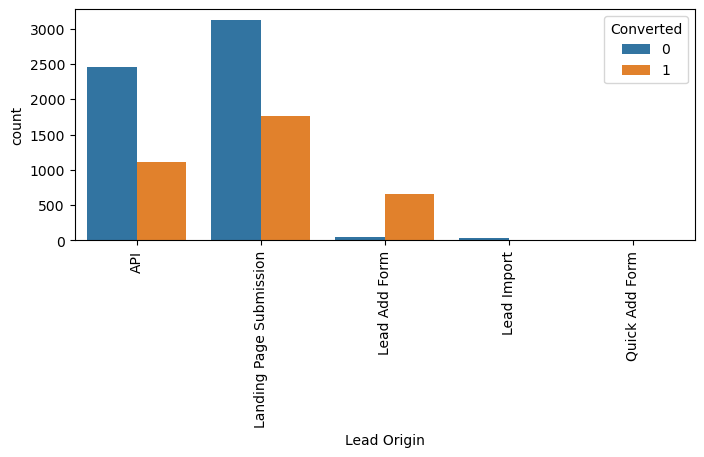

In [700]:
plt.figure(figsize=(8,3))
s1=sns.countplot(x=leads['Lead Origin'], hue=leads.Converted)
s1.set_xticklabels(s1.get_xticklabels(),rotation=90)
plt.show()

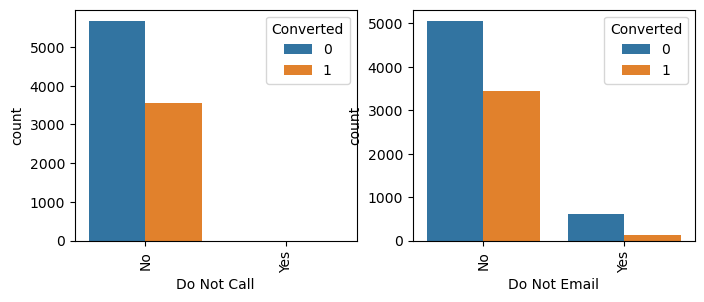

In [701]:
#Plotting Do not call and Do not Email variables against the converted varilable.
plt.figure(figsize=(8,3))

ax1=plt.subplot(1, 2, 1)
ax1=sns.countplot(x=leads['Do Not Call'], hue=leads.Converted)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)

ax2=plt.subplot(1, 2, 2)
ax2=sns.countplot(x=leads['Do Not Email'], hue=leads.Converted)
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90)
plt.show()

In [702]:
# Checking actual count of the variable value
leads['Do Not Call'].value_counts(dropna=False)

Do Not Call
No     9238
Yes       2
Name: count, dtype: int64

In [703]:
# Checking actual count of the variable value
leads['Do Not Email'].value_counts(dropna=False)

Do Not Email
No     8506
Yes     734
Name: count, dtype: int64

In [704]:
# Since the variable 'Do not Call' is highly biased, we plan to drop the variable
cols_to_drop.append('Do Not Call')
cols_to_drop

['What matters most to you in choosing a course', 'Country', 'Do Not Call']

In [705]:
leads.Search.value_counts(dropna=False)

Search
No     9226
Yes      14
Name: count, dtype: int64

In [706]:
leads['Newspaper Article'].value_counts(dropna=False)

Newspaper Article
No     9238
Yes       2
Name: count, dtype: int64

In [707]:
leads['X Education Forums'].value_counts(dropna=False)

X Education Forums
No     9239
Yes       1
Name: count, dtype: int64

In [708]:
leads['Newspaper'].value_counts(dropna=False)

Newspaper
No     9239
Yes       1
Name: count, dtype: int64

In [709]:
leads['Digital Advertisement'].value_counts(dropna=False)

Digital Advertisement
No     9236
Yes       4
Name: count, dtype: int64

In [710]:
leads['Through Recommendations'].value_counts(dropna=False)

Through Recommendations
No     9233
Yes       7
Name: count, dtype: int64

In [711]:
leads['Receive More Updates About Our Courses'].value_counts(dropna=False)

Receive More Updates About Our Courses
No    9240
Name: count, dtype: int64

In [712]:
leads['Update me on Supply Chain Content'].value_counts(dropna=False)

Update me on Supply Chain Content
No    9240
Name: count, dtype: int64

In [713]:
leads['Get updates on DM Content'].value_counts(dropna=False)

Get updates on DM Content
No    9240
Name: count, dtype: int64

In [714]:
leads['I agree to pay the amount through cheque'].value_counts(dropna=False)

I agree to pay the amount through cheque
No    9240
Name: count, dtype: int64

In [715]:
leads['A free copy of Mastering The Interview'].value_counts(dropna=False)

A free copy of Mastering The Interview
No     6352
Yes    2888
Name: count, dtype: int64

In [716]:
cols_to_drop.extend(['Search','Magazine','Newspaper Article','X Education Forums','Newspaper',
                 'Digital Advertisement','Through Recommendations','Receive More Updates About Our Courses',
                 'Update me on Supply Chain Content',
                 'Get updates on DM Content','I agree to pay the amount through cheque'])

In [717]:
leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        3407
Email Opened                    2827
SMS Sent                        2172
Page Visited on Website          318
Olark Chat Conversation          183
Email Link Clicked               173
Email Bounced                     60
Unsubscribed                      47
Unreachable                       32
Had a Phone Conversation          14
Email Marked Spam                  2
Approached upfront                 1
Resubscribed to emails             1
View in browser link Clicked       1
Form Submitted on Website          1
Email Received                     1
Name: count, dtype: int64

In [718]:
leads['Last Notable Activity'] = leads['Last Notable Activity'].replace(['Had a Phone Conversation',
                                                                       'Email Marked Spam',
                                                                         'Unreachable',
                                                                         'Unsubscribed',
                                                                         'Email Bounced',                                                                    
                                                                       'Resubscribed to emails',
                                                                       'View in browser link Clicked',
                                                                       'Approached upfront', 
                                                                       'Form Submitted on Website', 
                                                                       'Email Received'],'Other_Notable_activity')


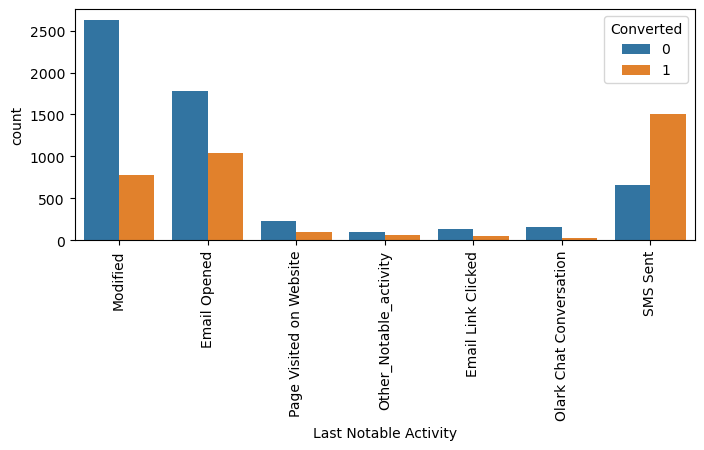

In [719]:

plt.figure(figsize = (8,3))
ax1=sns.countplot(x = "Last Notable Activity", hue = "Converted", data = leads)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=90)
plt.show()

In [720]:
leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                   3407
Email Opened               2827
SMS Sent                   2172
Page Visited on Website     318
Olark Chat Conversation     183
Email Link Clicked          173
Other_Notable_activity      160
Name: count, dtype: int64

In [721]:
cols_to_drop

['What matters most to you in choosing a course',
 'Country',
 'Do Not Call',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque']

In [722]:
leads = leads.drop(cols_to_drop,axis = 1)
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9240 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9103 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  Tags                                    9240 non-null   obje

In [723]:
Converted = (sum(leads['Converted'])/len(leads['Converted'].index))*100
Converted

38.53896103896104

In [724]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Lead Origin                             9240 non-null   object 
 1   Lead Source                             9240 non-null   object 
 2   Do Not Email                            9240 non-null   object 
 3   Converted                               9240 non-null   int64  
 4   TotalVisits                             9103 non-null   float64
 5   Total Time Spent on Website             9240 non-null   int64  
 6   Page Views Per Visit                    9103 non-null   float64
 7   Last Activity                           9240 non-null   object 
 8   Specialization                          9240 non-null   object 
 9   What is your current occupation         9240 non-null   object 
 10  Tags                                    9240 non-null   obje

### Now that all data is set, we find the correlation matrix of numeric variables.

In [725]:
numcol= leads.select_dtypes(include=['int64','float64']).columns
corl=leads[numcol]

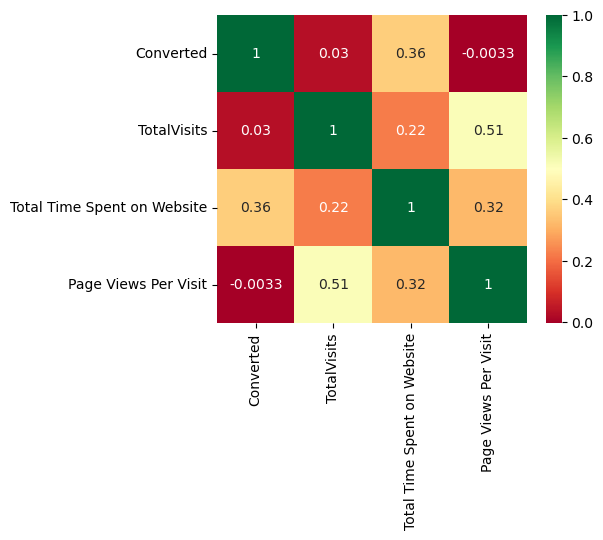

In [726]:
plt.figure(figsize=(5,4))

# heatmap
sns.heatmap(data=corl.corr(), cmap="RdYlGn", annot=True)
plt.show()

### Analysis-
1. Converted has highest corelation with the total time spent on website, which means more time spent on the website will be a potential lead worthy of conversion.
2. Also, page views per visit has the least corelation with converted variable, which means the conversion rate cannot be predicted with the number of pages viewed on a visit.


### Handling Outliers

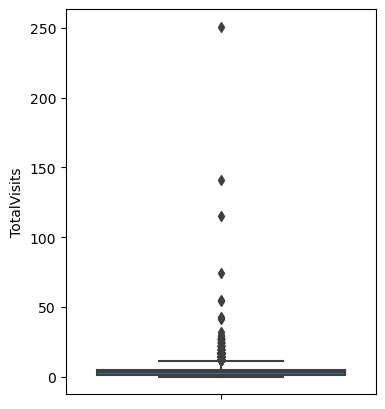

In [727]:
plt.figure(figsize=(4,5))
sns.boxplot(y=leads['TotalVisits'])
plt.show()

In [728]:
#bucketing the total Visits values
leads['TotalVisits'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
5%          0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

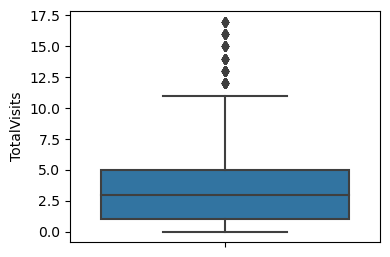

In [729]:
# working on the interquartile range of qtr3 and qtr1

plt.figure(figsize=(4,3))
Q3 = leads.TotalVisits.quantile(0.99)
leads = leads[(leads.TotalVisits <= Q3)]
Q1 = leads.TotalVisits.quantile(0.01)
leads = leads[(leads.TotalVisits >= Q1)]
sns.boxplot(y=leads['TotalVisits'])
plt.show()

In [730]:
leads.shape

(9020, 14)

In [731]:
#bucketing the 'Total Time Spent on Website' values
leads['Total Time Spent on Website'].describe(percentiles=[0.05,.25, .5, .75, .90, .95, .99])

count    9020.000000
mean      479.759534
std       544.688157
min         0.000000
5%          0.000000
25%         7.000000
50%       243.000000
75%       915.250000
90%      1371.000000
95%      1554.050000
99%      1836.620000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

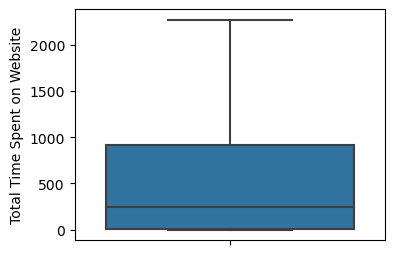

In [732]:
plt.figure(figsize=(4,3))
sns.boxplot(y=leads['Total Time Spent on Website'])
plt.show()

In [733]:
leads['Page Views Per Visit'].describe()


count    9020.000000
mean        2.337271
std         2.062363
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        16.000000
Name: Page Views Per Visit, dtype: float64

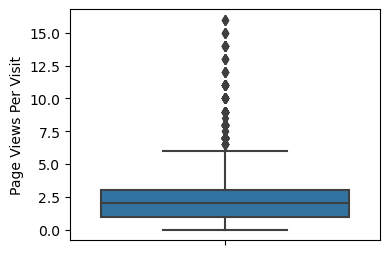

In [734]:
plt.figure(figsize=(4,3))
sns.boxplot(y=leads['Page Views Per Visit'])
plt.show()

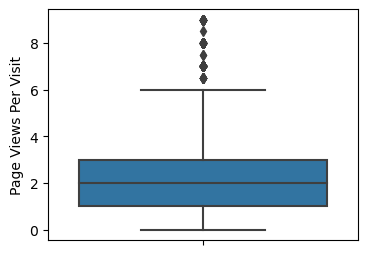

In [735]:
# working on the interquartile range of qtr3 and qtr1

plt.figure(figsize=(4,3))
Q3 = leads['Page Views Per Visit'].quantile(0.99)
leads = leads[leads['Page Views Per Visit'] <= Q3]
Q1 = leads['Page Views Per Visit'].quantile(0.01)
leads = leads[leads['Page Views Per Visit'] >= Q1]
sns.boxplot(y=leads['Page Views Per Visit'])
plt.show()

In [736]:
leads.shape

(8953, 14)

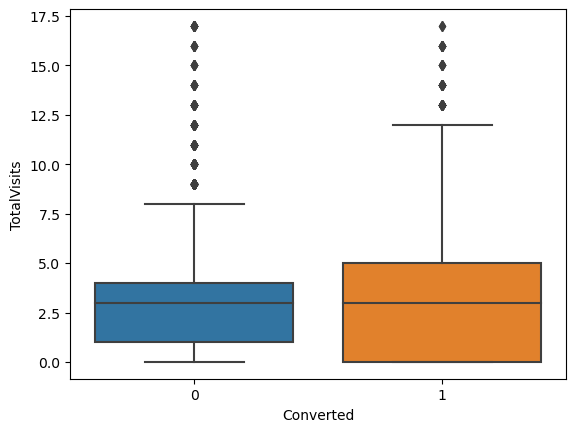

In [737]:
# Plotting a boxplot for converted and total visits.
sns.boxplot(y = 'TotalVisits', x = 'Converted', data = leads)
plt.show()

### Analysis-
1. The not converted vs converted mean are around the same region, whereas the amount of conversion is fairly smaller.
The upper quartile is almost the same for both converted and not converted categories.

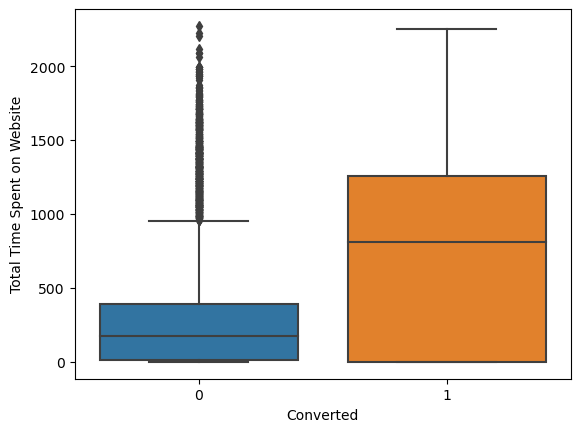

In [738]:
sns.boxplot(x=leads.Converted, y=leads['Total Time Spent on Website'])
plt.show()

### analysis-
As seen earlier, higher the time spent on the webpage, higher is the conversion rate of the lead.
Thus those custmers who spend more time on the web page should be considered high potential leads.

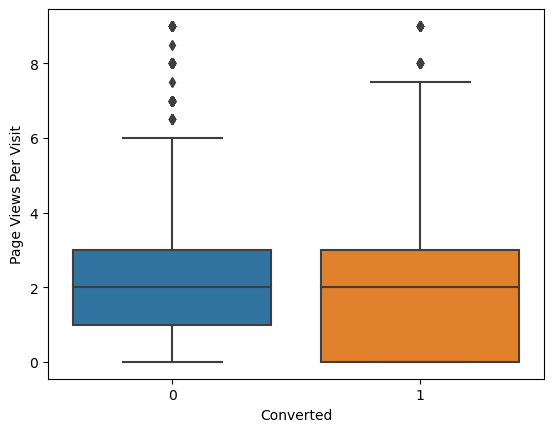

In [739]:
sns.boxplot(x=leads.Converted,y=leads['Page Views Per Visit'])
plt.show()

### Analysis-
1. The median of the average page views for converted is higher than for not converted.
2. If a lead views more number of pages as compared to the average number of page visits, they can be considered as a potential leads.

In [740]:
round(100*(leads.isnull().sum()/len(leads.index)),2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Last Activity                             0.0
Specialization                            0.0
What is your current occupation           0.0
Tags                                      0.0
City                                      0.0
A free copy of Mastering The Interview    0.0
Last Notable Activity                     0.0
dtype: float64

In [741]:
catcol= leads.select_dtypes(include=['object']).columns
catcol

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

## Define the target variable

### The target variable: (Converted)
* The target variable Converted indicates whether a lead was successfully turned into a paying customer, with a value of 1 representing conversion and 0 representing non-conversion.
* In the provided dataset, Converted serves as the outcome that the model will predict, helping X Education identify the leads most likely to result in sales.
* The goal is to maximize the Converted rate by focusing efforts on leads with the highest potential, as determined by the model's lead scoring system.

In [742]:
leads['Converted'].value_counts()

Converted
0    5558
1    3395
Name: count, dtype: int64

## Create dummy variables for the independent variables

In [743]:
catcol


Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags', 'City',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [744]:
for col in catcol:
     
     print('\n\n',leads[col].value_counts())
   



 Lead Origin
Landing Page Submission    4769
API                        3546
Lead Add Form               607
Lead Import                  31
Name: count, dtype: int64


 Lead Source
Google              2841
Direct Traffic      2499
Olark Chat          1751
Organic Search      1092
Reference            442
Welingak Website     129
Referral Sites       117
Others                47
Social Media          33
Live Chat              2
Name: count, dtype: int64


 Do Not Email
No     8256
Yes     697
Name: count, dtype: int64


 Last Activity
Email Opened                 3390
SMS Sent                     2700
Olark Chat Conversation       966
Page Visited on Website       594
Converted to Lead             428
Email Bounced                 310
Email Link Clicked            264
Others                        187
Form Submitted on Website     114
Name: count, dtype: int64


 Specialization
Management_Specializations           4126
None                                 3284
Business Administration

In [745]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy = pd.get_dummies(leads[catcol], drop_first=True)

# Adding the results to the master dataframe
leads = pd.concat([leads, dummy], axis=1)

In [746]:
leads.head()

Lead Origin     Lead Source Do Not Email  Converted  \
0                      API      Olark Chat           No          0   
1                      API  Organic Search           No          0   
2  Landing Page Submission  Direct Traffic           No          1   
3  Landing Page Submission  Direct Traffic           No          0   
4  Landing Page Submission          Google           No          1   

   TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

             Last Activity           Specialization  \
0  Page Visited on Website                     None   
1             Email Opened                     None   
2             Email Opened  Business Administration   
3                   Others    Media and Advertising   
4        Converted to Lead                     None   

  What is your current occupation                                 Tags  \
0                      Unemployed          Interested in other courses   
1                      Unemployed                              Ringing   
2                         Student  Will revert after reading the email   
3                      Unemployed                              Ringing   
4                      Unemployed  Will revert after reading the email   

     City A free copy of Mastering The Interview Last Notable Activity  \
0  Mumbai                                     No              Modified   
1  Mumbai                                     No          Email Opened   
2  Mumbai                                    Yes          Email Opened   
3  Mumbai                                     No              Modified   
4  Mumbai                                     No              Modified   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                False                      False   
1                                False                      False   
2                                 True                      False   
3                                 True                      False   
4                                 True                      False   

   Lead Origin_Lead Import  Lead Source_Google  Lead Source_Live Chat  \
0                    False               False                  False   
1                    False               False                  False   
2                    False               False                  False   
3                    False               False                  False   
4                    False                True                  False   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                    True                       False               False   
1                   False                        True               False   
2                   False                       False               False   
3                   False                       False               False   
4                   False                       False               False   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                  False                       False   
1                  False                       False   
2                  False                       False   
3                  False                       False   
4                  False                       False   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
0                     False                         False             False   
1                     False                         False             False   
2                     False                         False          

In [747]:
leads=leads.drop(catcol,axis=1)

In [748]:
leads.head()

Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0          0.0                            0                   0.0   
1          0          5.0                          674                   2.5   
2          1          2.0                         1532                   2.0   
3          0          1.0                          305                   1.0   
4          1          2.0                         1428                   1.0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                False                      False   
1                                False                      False   
2                                 True                      False   
3                                 True                      False   
4                                 True                      False   

   Lead Origin_Lead Import  Lead Source_Google  Lead Source_Live Chat  \
0                    False               False                  False   
1                    False               False                  False   
2                    False               False                  False   
3                    False               False                  False   
4                    False                True                  False   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                    True                       False               False   
1                   False                        True               False   
2                   False                       False               False   
3                   False                       False               False   
4                   False                       False               False   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                  False                       False   
1                  False                       False   
2                  False                       False   
3                  False                       False   
4                  False                       False   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
0                     False                         False             False   
1                     False                         False             False   
2                     False                         False             False   
3                     False                         False             False   
4                     False                         False             False   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
0                        False                             False   
1                        False                             False   
2                        False                             False   
3                        False                             False   
4                        False                             False   

   Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
0                       False                                    False   
1                        True                                    False   
2                        True                                    False   
3                       False                                    False   
4                       False                                    False   

   Last Activity_Olark Chat Conversation  Last Activity_Others  \
0                                  False                 False   
1                                  False                 False   
2                                  False                 False   
3                                  False                  True   
4                                  False                 False   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
0                                   True                   False   
1     

In [749]:
catcol= leads.select_dtypes(include=['bool']).columns
catcol

Index(['Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Origin_Lead Import', 'Lead Source_Google',
       'Lead Source_Live Chat', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Others',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_Welingak Website',
       'Do Not Email_Yes', 'Last Activity_Email Bounced',
       'Last Activity_Email Link Clicked', 'Last Activity_Email Opened',
       'Last Activity_Form Submitted on Website',
       'Last Activity_Olark Chat Conversation', 'Last Activity_Others',
       'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_International Business',
       'Specialization_Management_Specializations',
       'Specialization_Media and Advertising', 'Specialization_None',
       'Specializat

In [750]:
for col in catcol:
    leads[col]=leads[col].astype(int)

In [751]:
leads.head()

Converted  TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0          0.0                            0                   0.0   
1          0          5.0                          674                   2.5   
2          1          2.0                         1532                   2.0   
3          0          1.0                          305                   1.0   
4          1          2.0                         1428                   1.0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Source_Google  Lead Source_Live Chat  \
0                        0                   0                      0   
1                        0                   0                      0   
2                        0                   0                      0   
3                        0                   0                      0   
4                        0                   1                      0   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
0                         0                             0                 0   
1                         0                             0                 0   
2                         0                             0                 0   
3                         0                             0                 0   
4                         0                             0                 0   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
0                            0                                 0   
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   

   Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
0                           0                                        0   
1                           1                                        0   
2                           1                                        0   
3                           0                                        0   
4                           0                                        0   

   Last Activity_Olark Chat Conversation  Last Activity_Others  \
0                                      0                     0   
1                                      0                     0   
2                                      0                     0   
3                                      0                     1   
4                                      0                     0   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
0                                      1                       0   
1     

## Training - Test Data Split

##### Putting feature variable to X

In [752]:
X = leads.drop(['Converted'], axis=1)

X.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
0          0.0                            0                   0.0   
1          5.0                          674                   2.5   
2          2.0                         1532                   2.0   
3          1.0                          305                   1.0   
4          2.0                         1428                   1.0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Source_Google  Lead Source_Live Chat  \
0                        0                   0                      0   
1                        0                   0                      0   
2                        0                   0                      0   
3                        0                   0                      0   
4                        0                   1                      0   

   Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
0                       1                           0                   0   
1                       0                           1                   0   
2                       0                           0                   0   
3                       0                           0                   0   
4                       0                           0                   0   

   Lead Source_Reference  Lead Source_Referral Sites  \
0                      0                           0   
1                      0                           0   
2                      0                           0   
3                      0                           0   
4                      0                           0   

   Lead Source_Social Media  Lead Source_Welingak Website  Do Not Email_Yes  \
0                         0                             0                 0   
1                         0                             0                 0   
2                         0                             0                 0   
3                         0                             0                 0   
4                         0                             0                 0   

   Last Activity_Email Bounced  Last Activity_Email Link Clicked  \
0                            0                                 0   
1                            0                                 0   
2                            0                                 0   
3                            0                                 0   
4                            0                                 0   

   Last Activity_Email Opened  Last Activity_Form Submitted on Website  \
0                           0                                        0   
1                           1                                        0   
2                           1                                        0   
3                           0                                        0   
4                           0                                        0   

   Last Activity_Olark Chat Conversation  Last Activity_Others  \
0                                      0                     0   
1                                      0                     0   
2                                      0                     0   
3                                      0                     1   
4                                      0                     0   

   Last Activity_Page Visited on Website  Last Activity_SMS Sent  \
0                                      1                       0   
1                                      0                       0   
2   

##### Putting response variable to y

In [753]:
y=leads['Converted']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

##### Splitting the data set into test and train

In [754]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [755]:
X_train.shape

(6267, 58)

In [756]:
y_train.shape

(6267,)

In [757]:
X_test.shape

(2686, 58)

In [758]:
y_test.shape

(2686,)

## Fine tuning and Analysis

##### Feature Scaling the numerical variables

In [759]:
numcol

Index(['Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit'],
      dtype='object')

In [760]:
scaler = StandardScaler()

X_train[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

TotalVisits  Total Time Spent on Website  Page Views Per Visit  \
9196     0.668862                     1.848117              1.455819   
4696    -0.030697                    -0.037832              0.399961   
3274     0.319082                    -0.642138             -0.127967   
2164    -0.380477                    -0.154676             -0.127967   
1667     0.319082                     1.258415             -0.481679   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
9196                                    1                          0   
4696                                    1                          0   
3274                                    1                          0   
2164                                    0                          0   
1667                                    0                          0   

      Lead Origin_Lead Import  Lead Source_Google  Lead Source_Live Chat  \
9196                        0                   1                      0   
4696                        0                   0                      0   
3274                        0                   1                      0   
2164                        0                   1                      0   
1667                        0                   1                      0   

      Lead Source_Olark Chat  Lead Source_Organic Search  Lead Source_Others  \
9196                       0                           0                   0   
4696                       0                           0                   0   
3274                       0                           0                   0   
2164                       0                           0                   0   
1667                       0                           0                   0   

      Lead Source_Reference  Lead Source_Referral Sites  \
9196                      0                           0   
4696                      0                           0   
3274                      0                           0   
2164                      0                           0   
1667                      0                           0   

      Lead Source_Social Media  Lead Source_Welingak Website  \
9196                         0                             0   
4696                         0                             0   
3274                         0                             0   
2164                         0                             0   
1667                         0                             0   

      Do Not Email_Yes  Last Activity_Email Bounced  \
9196                 0                            0   
4696                 0                            0   
3274                 0                            0   
2164                 0                            0   
1667                 0                            0   

      Last Activity_Email Link Clicked  Last Activity_Email Opened  \
9196                                 0                           0   
4696                                 0                           0   
3274                                 0                           0   
2164                                 0                           0   
1667                                 0                           1   

      Last Activity_Form Submitted on Website  \
9196                                        0   
4696                                        0   
3274                                        0   
2164                                        0   
1667                                        0   

      Last Activity_Olark Chat Conversation  Last Activity_Others  \
9196                                      0                     0   
4696                                      0                     0   
3274                                      0                     0   
2164                                      1                     0   
1667                                      0                     0   



#### Looking at the correlations

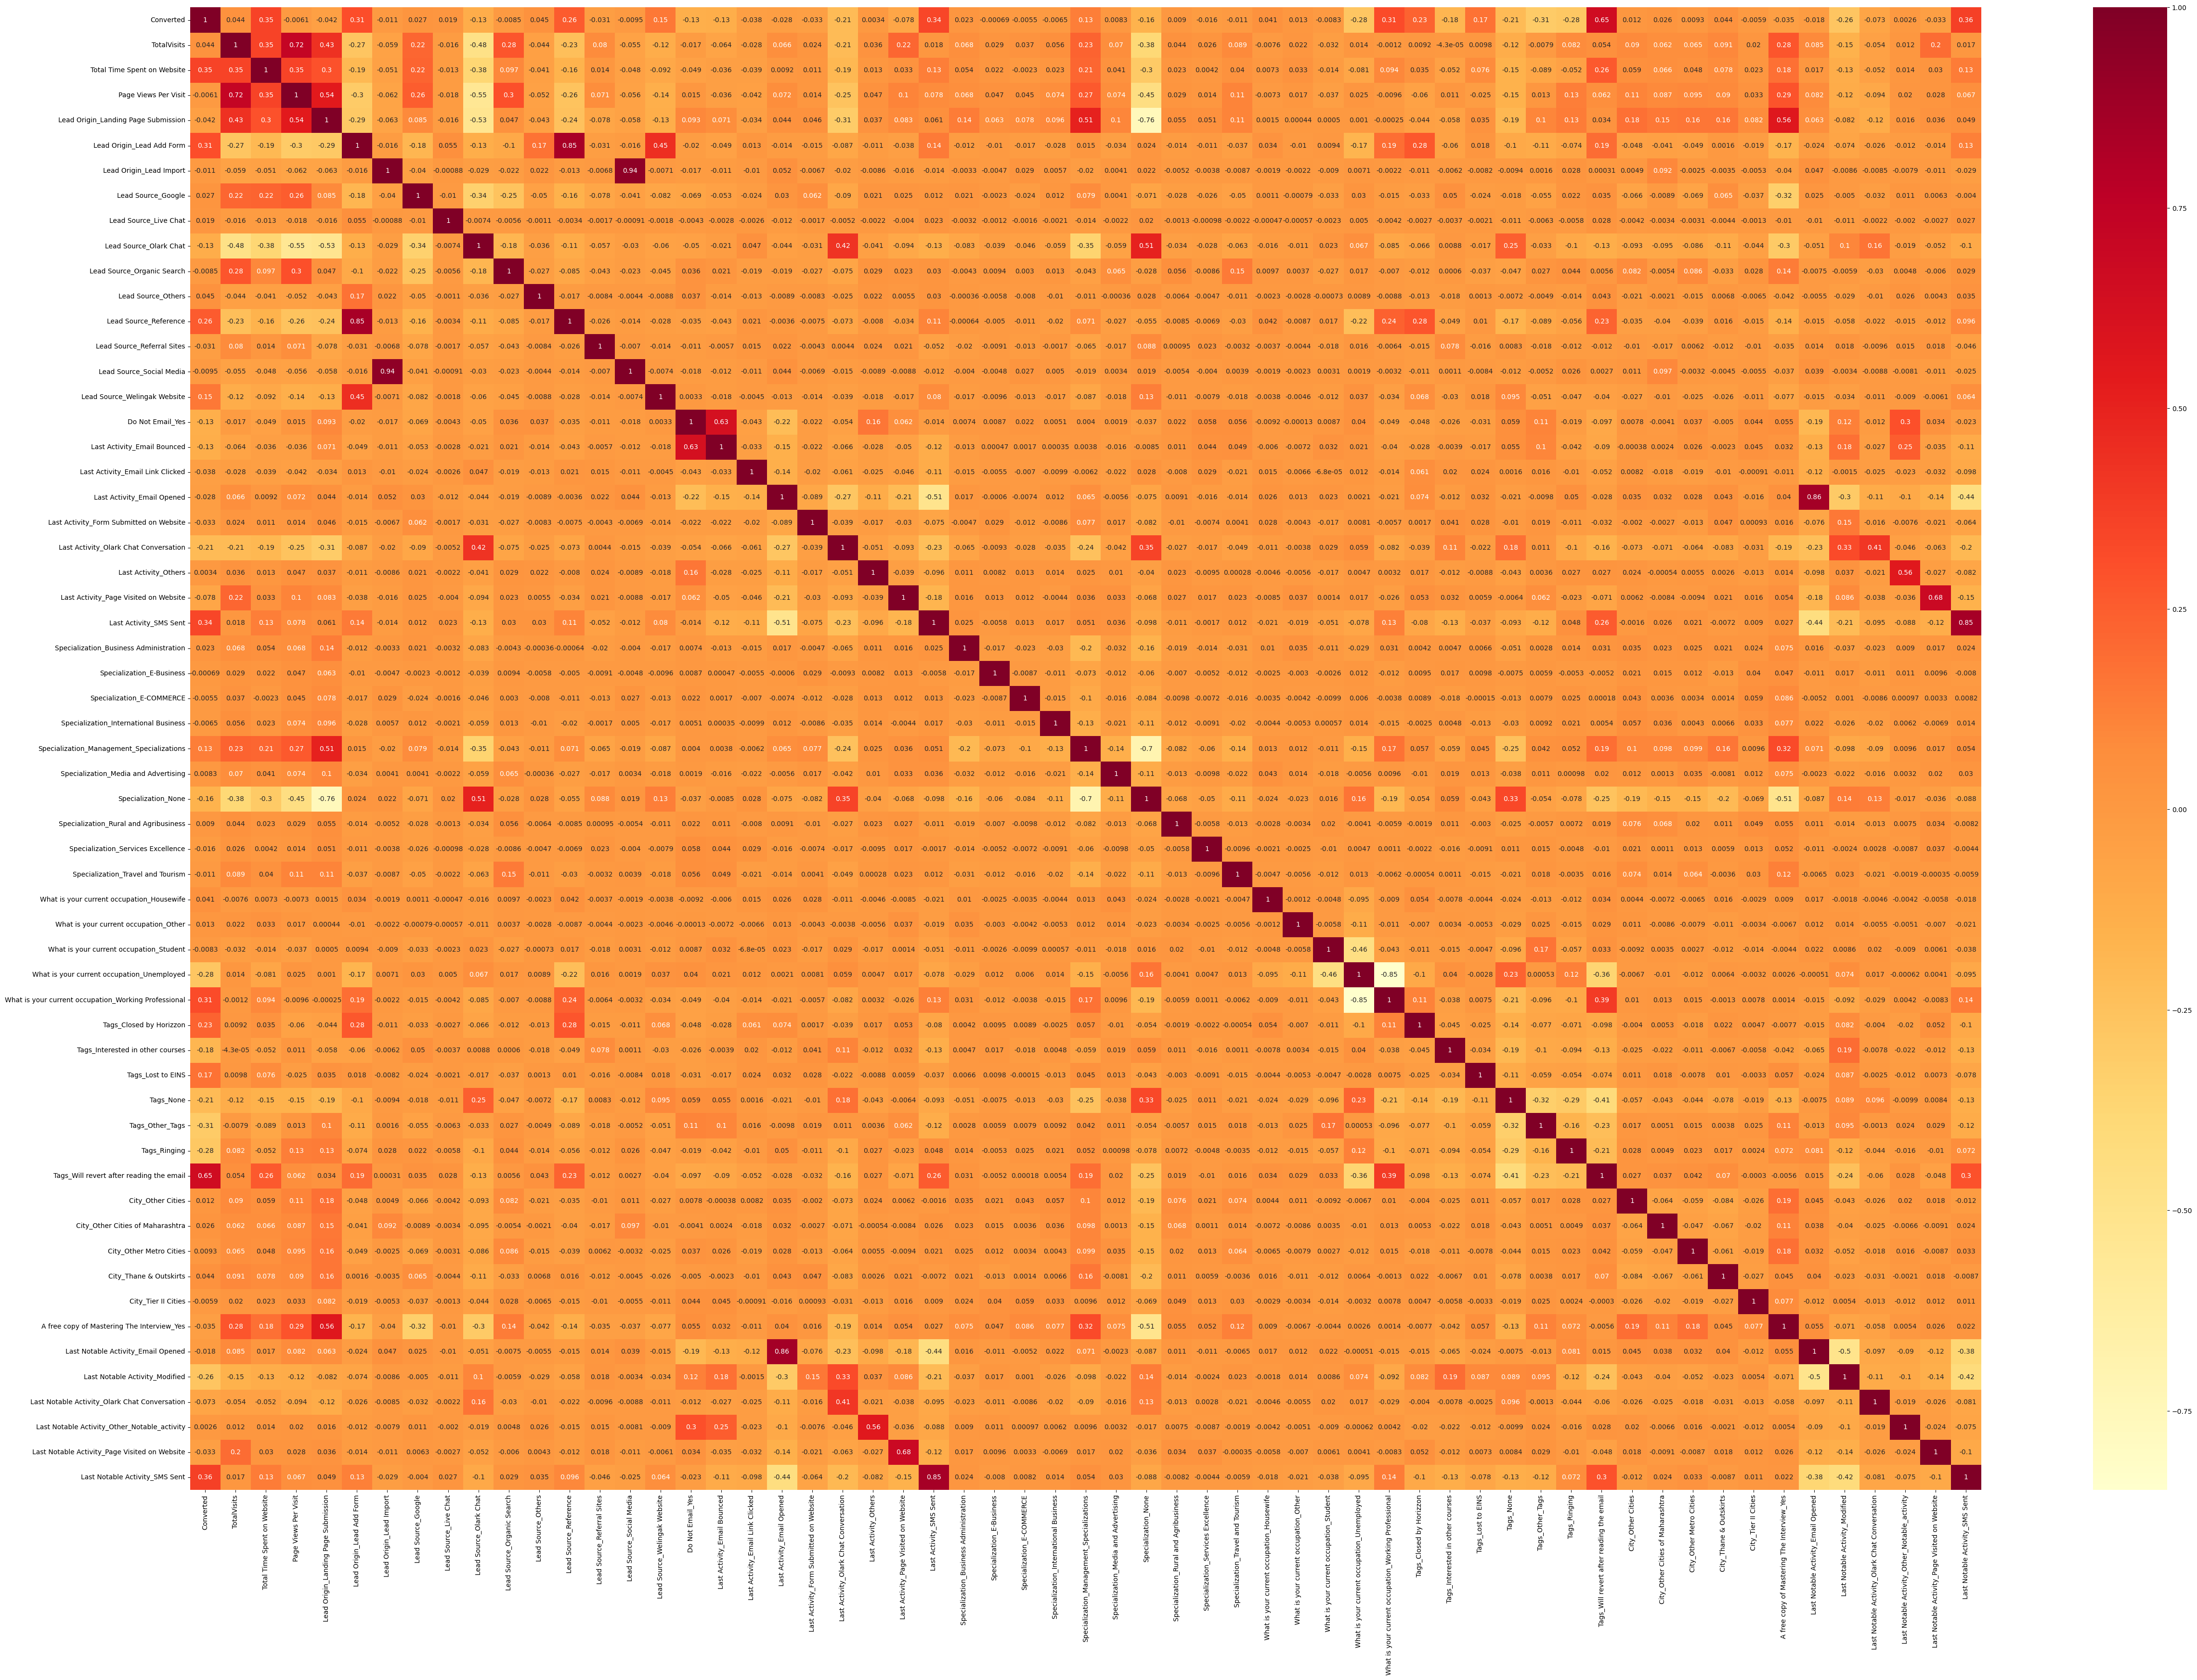

In [761]:
plt.figure(figsize = (60,40))        # Size of the figure
sns.heatmap(leads.corr(),cmap='YlOrRd',annot = True)
plt.savefig("sample_plot.pdf")
plt.show()

In [762]:
high_corr=['Lead Origin_Lead Add Form','Specialization_None','What is your current occupation_Unemployed','Last Notable Activity_Email Opened','Last Notable Activity_SMS Sent']

##### Dropping highly correlated dummy variables

In [763]:
X_test = X_test.drop(high_corr, axis=1)
X_train = X_train.drop(high_corr, axis=1)


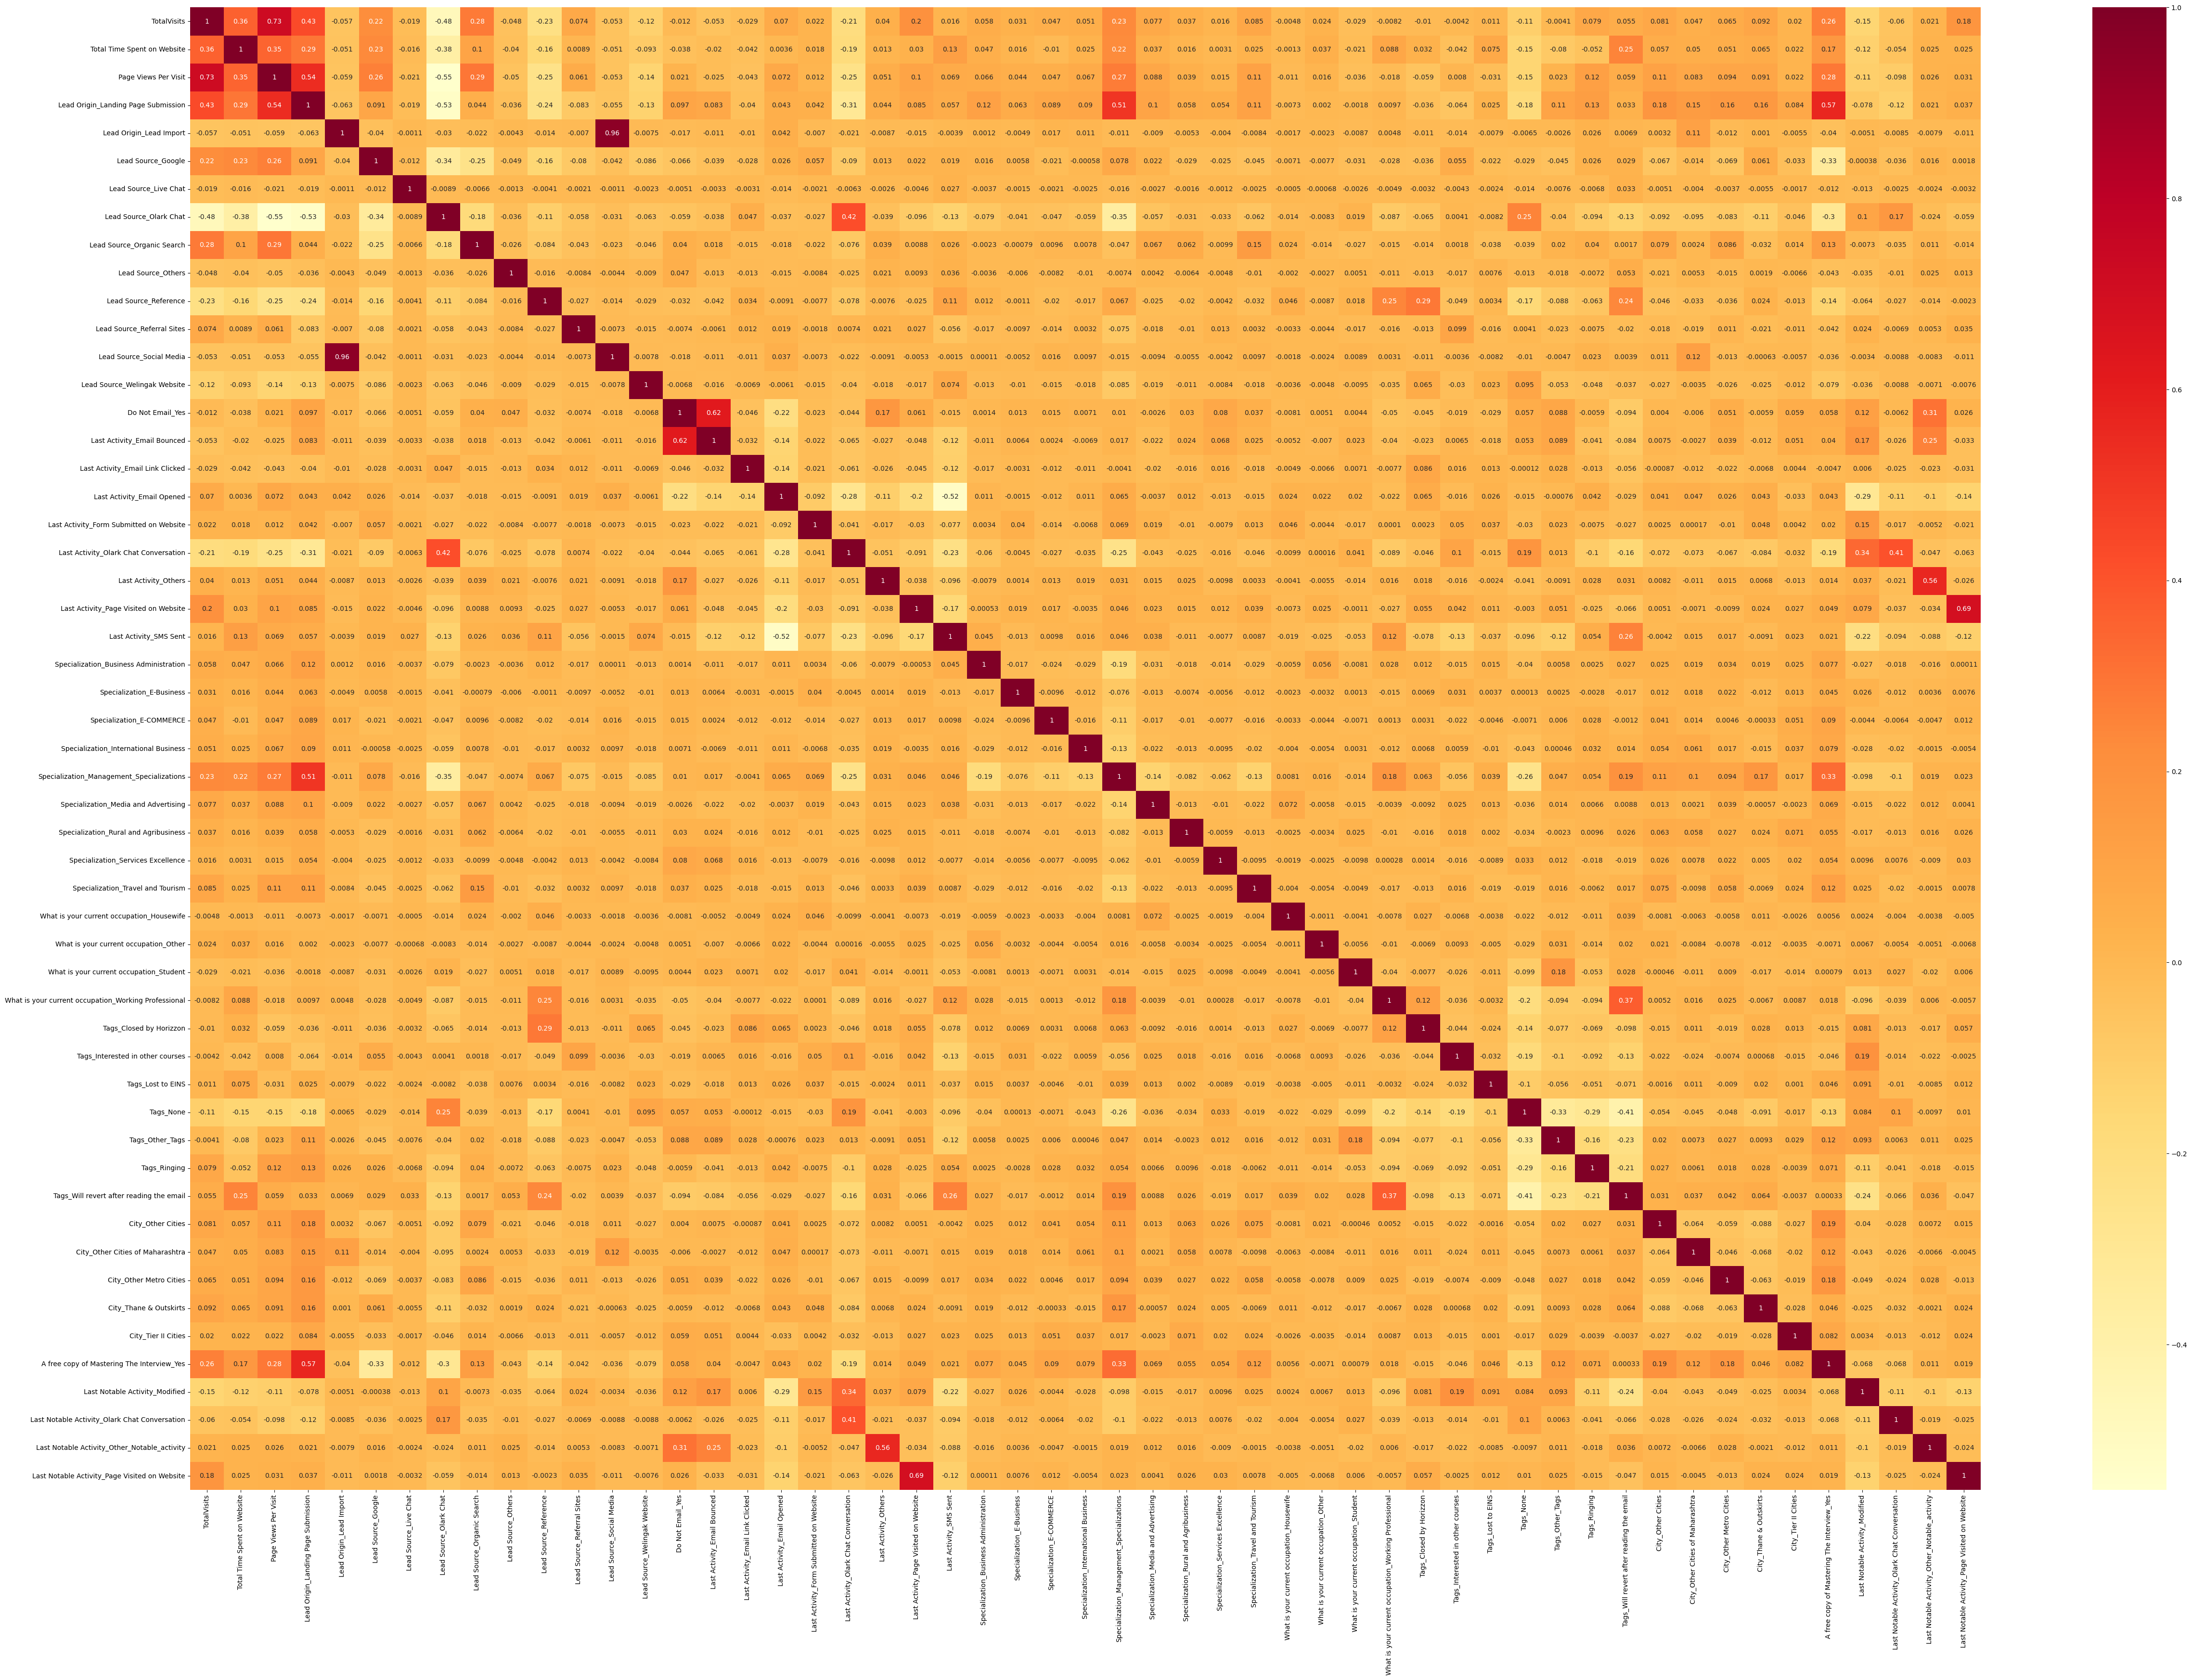

In [764]:
plt.figure(figsize = (60,40))
sns.heatmap(X_train.corr(),cmap='YlOrRd',annot = True)
plt.savefig("sample_plot2.pdf")
plt.show()

##### Model Building

In [765]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6267
Model:                            GLM   Df Residuals:                     6213
Model Family:                Binomial   Df Model:                           53
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1189.1
Date:                Tue, 20 Aug 2024   Deviance:                       2378.2
Time:                        20:10:51   Pearson chi2:                 8.21e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.6129
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.7926      0.477     -1.663      0.096      -1.727       0.142
TotalVisits                                              0.2061      0.076      2.698      0.007       0.056       0.356
Total Time Spent on Website                              1.0916      0.064     17.150      0.000       0.967       1.216
Page Views Per Visit                                    -0.2543      0.096     -2.661      0.008      -0.442      -0.067
Lead Origin_Landing Page Submission                     -0.5792      0.214     -2.706      0.007      -0.999      -0.160
Lead Origin_Lead Import                                 22.8423   2.47e+04      0.001      0.999   -4.85e+04    4.85e+04
Lead Source_Google                                       0.1934      0.190      1.020      0.308      -0.178       0.565
Lead Source_Live Chat                                   18.0955   3.41e+04      0.001      1.000   -6.68e+04    6.68e+04
Lead Source_Olark Chat                                   0.9531      0.252      3.788      0.000       0.460       1.446
Lead Source_Organic Search                               0.1868      0.220      0.851      0.395      -0.244       0.617
Lead Source_Others                                       2.3002      0.768      2.995      0.003       0.795       3.806
Lead Source_Reference                                    1.5998      0.558      2.869      0.004       0.507       2.693
Lead Source_Referral Sites                              -0.1430      0.507     -0.282      0.778      -1.137       0.851
Lead Source_Social Media                               -22.0900   2.47e+04     -0.001      0.999   -4.85e+04    4.85e+04
Lead Source_Welingak Website                             5.9623      1.051      5.672      0.000       3.902       8.023
Do Not Email_Yes                                        -0.8130      0.301     -2.702      0.007      -1.403      -0.223
Last Activity_Email Bounced                             -0.2341      0.714     -0.328      0.743      -1.633       1.165
Last Activity_Email Link Clicked                        -0.3408      0.509     -0.669      0.503      -1.339       0.658
Last Activity_Email Opened                               0.3117      0.388      0.803      0.422      -0.449       1.072
Last Activity_Form Submitted on Website                  1.0873      0.611      1.780      0.075      -0.110       2.285
Last Activity_Olark Chat Conversation                   -0.3751      0.442     -0.850      0.396      -1.240       0.490
Last Activity_Others                                     0.1462      0.704      0.208      0.835      -1.233       1.526
Last Activity_Page Visited on Website                    0

##### Feature Selection using RFE

In [766]:
logreg = LogisticRegression()

##### keeping top 15 features

In [767]:
rfe = RFE(estimator=logreg, n_features_to_select=15)           
rfe = rfe.fit(X_train, y_train)

In [768]:
rfe.support_

array([False,  True, False,  True, False, False, False, False, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False, False, False,  True,  True, False, False])

In [769]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 24),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 23),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Import', False, 13),
 ('Lead Source_Google', False, 38),
 ('Lead Source_Live Chat', False, 37),
 ('Lead Source_Olark Chat', False, 6),
 ('Lead Source_Organic Search', False, 33),
 ('Lead Source_Others', True, 1),
 ('Lead Source_Reference', True, 1),
 ('Lead Source_Referral Sites', False, 11),
 ('Lead Source_Social Media', False, 20),
 ('Lead Source_Welingak Website', True, 1),
 ('Do Not Email_Yes', False, 3),
 ('Last Activity_Email Bounced', False, 12),
 ('Last Activity_Email Link Clicked', False, 9),
 ('Last Activity_Email Opened', False, 22),
 ('Last Activity_Form Submitted on Website', False, 5),
 ('Last Activity_Olark Chat Conversation', False, 7),
 ('Last Activity_Others', False, 26),
 ('Last Activity_Page Visited on Website', False, 28),
 ('Last Activity_SMS Sent', True, 1),
 ('Specialization_Business 

In [770]:
feature_select=X_train.columns[rfe.support_]

In [771]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit', 'Lead Origin_Lead Import',
       'Lead Source_Google', 'Lead Source_Live Chat', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Do Not Email_Yes',
       'Last Activity_Email Bounced', 'Last Activity_Email Link Clicked',
       'Last Activity_Email Opened', 'Last Activity_Form Submitted on Website',
       'Last Activity_Olark Chat Conversation', 'Last Activity_Others',
       'Last Activity_Page Visited on Website',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_E-COMMERCE', 'Specialization_International Business',
       'Specialization_Management_Specializations',
       'Specialization_Media and Advertising',
       'Specialization_Rural and Agribusiness',
       'Specialization_Services Excellence',
       'Specialization_Travel and Tourism',
       'What is your current occupation_Housewife',
       '

In [772]:
X_train_sm = sm.add_constant(X_train[feature_select])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6267
Model:                            GLM   Df Residuals:                     6251
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1235.6
Date:                Tue, 20 Aug 2024   Deviance:                       2471.1
Time:                        20:11:09   Pearson chi2:                 8.34e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.6072
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.8234      0.093     -8.882      0.000      -1.005      -0.642
Total Time Spent on Website                              0.9825      0.055     17.735      0.000       0.874       1.091
Lead Origin_Landing Page Submission                     -1.1054      0.117     -9.443      0.000      -1.335      -0.876
Lead Source_Others                                       1.8531      0.755      2.456      0.014       0.374       3.332
Lead Source_Reference                                    1.0629      0.504      2.111      0.035       0.076       2.050
Lead Source_Welingak Website                             5.3082      1.022      5.195      0.000       3.306       7.311
Last Activity_SMS Sent                                   2.1001      0.116     18.057      0.000       1.872       2.328
What is your current occupation_Working Professional     1.0173      0.419      2.426      0.015       0.195       1.839
Tags_Closed by Horizzon                                  7.3097      1.023      7.144      0.000       5.304       9.315
Tags_Interested in other courses                        -2.2973      0.412     -5.575      0.000      -3.105      -1.490
Tags_Lost to EINS                                        5.9359      0.613      9.683      0.000       4.734       7.137
Tags_Other_Tags                                         -2.3493      0.209    -11.252      0.000      -2.759      -1.940
Tags_Ringing                                            -3.3895      0.240    -14.138      0.000      -3.859      -2.920
Tags_Will revert after reading the email                 4.5298      0.196     23.070      0.000       4.145       4.915
Last Notable Activity_Modified                          -1.6597      0.125    -13.234      0.000      -1.906      -1.414
Last Notable Activity_Olark Chat Conversation           -2.0309      0.487     -4.171      0.000      -2.985      -1.077
========================================================================================================================
"""

##### Getting the predicted values on the train set

In [773]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

9196    0.197436
4696    0.037138
3274    0.387102
2164    0.007158
1667    0.992916
7024    0.157062
8018    0.023866
778     0.106384
6942    0.003370
4440    0.094946
dtype: float64

In [774]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.19743607, 0.03713767, 0.38710155, 0.00715758, 0.99291561,
       0.15706158, 0.02386576, 0.10638362, 0.00337048, 0.09494587])

In [775]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

Converted  Converted_Prob  LeadID
0          1        0.197436    9196
1          0        0.037138    4696
2          0        0.387102    3274
3          0        0.007158    2164
4          1        0.992916    1667

In [776]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Converted  Converted_Prob  LeadID  predicted
0          1        0.197436    9196          0
1          0        0.037138    4696          0
2          0        0.387102    3274          0
3          0        0.007158    2164          0
4          1        0.992916    1667          1

##### Confusion Matrix

In [777]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3723  159]
 [ 284 2101]]


##### Overall Accuracy

In [778]:
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.929312270623903


##### Checking VIFs

In [779]:
vif = pd.DataFrame()
vif['Features'] = X_train[feature_select].columns
vif['VIF'] = [variance_inflation_factor(X_train[feature_select].values, i) for i in range(X_train[feature_select].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
1                 Lead Origin_Landing Page Submission  2.05
12           Tags_Will revert after reading the email  1.86
5                              Last Activity_SMS Sent  1.51
3                               Lead Source_Reference  1.46
13                     Last Notable Activity_Modified  1.45
6   What is your current occupation_Working Profes...  1.32
10                                    Tags_Other_Tags  1.31
11                                       Tags_Ringing  1.27
7                             Tags_Closed by Horizzon  1.26
0                         Total Time Spent on Website  1.25
8                    Tags_Interested in other courses  1.13
9                                   Tags_Lost to EINS  1.06
4                        Lead Source_Welingak Website  1.05
2                                  Lead Source_Others  1.02
14      Last Notable Activity_Olark Chat Conversation  1.01

##### All the varaibles have low VIF values indiacting no multicollinearity

In [780]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted)
confusion

array([[3723,  159],
       [ 284, 2101]])

In [781]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.929312270623903

## Metrics Beyond Accuracy

In [782]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [783]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8809224318658281

In [784]:
# Let us calculate specificity
TN / float(TN+FP)

0.9590417310664606

In [785]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.04095826893353941


In [786]:
# positive predictive value 
print (TP / float(TP+FP))

0.929646017699115


In [787]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9291240329423509


### Step 9: Plotting the ROC Curve

In [788]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [789]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

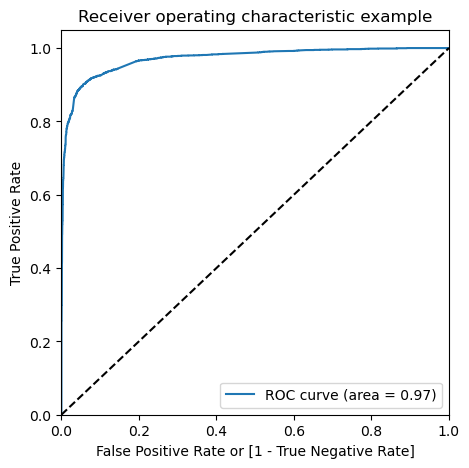

In [790]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

In [791]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Converted  Converted_Prob  LeadID  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0          1        0.197436    9196          0    1    1    0    0    0    0   
1          0        0.037138    4696          0    1    0    0    0    0    0   
2          0        0.387102    3274          0    1    1    1    1    0    0   
3          0        0.007158    2164          0    1    0    0    0    0    0   
4          1        0.992916    1667          1    1    1    1    1    1    1   

   0.6  0.7  0.8  0.9  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    1    1    1    1

In [792]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.380565  1.000000  0.000000
0.1   0.1  0.837243  0.971908  0.754508
0.2   0.2  0.901388  0.935430  0.880474
0.3   0.3  0.921334  0.914885  0.925296
0.4   0.4  0.926919  0.898113  0.944616
0.5   0.5  0.929312  0.880922  0.959042
0.6   0.6  0.926759  0.860797  0.967285
0.7   0.7  0.913196  0.805031  0.979650
0.8   0.8  0.907611  0.778616  0.986862
0.9   0.9  0.887187  0.718239  0.990984


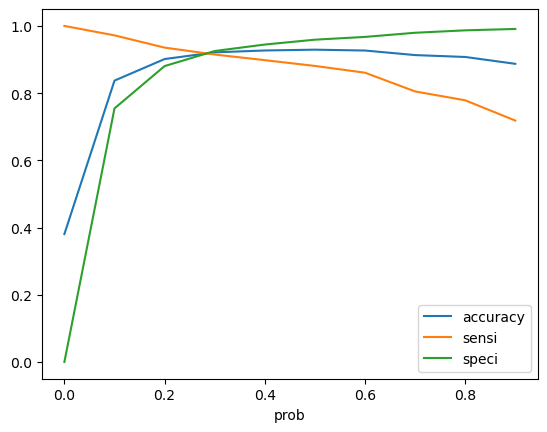

In [793]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### From the curve above, 0.3 is the optimum point to take it as a cutoff probability.

In [794]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

Converted  Converted_Prob  LeadID  predicted  0.0  0.1  0.2  0.3  0.4  0.5  \
0          1        0.197436    9196          0    1    1    0    0    0    0   
1          0        0.037138    4696          0    1    0    0    0    0    0   
2          0        0.387102    3274          0    1    1    1    1    0    0   
3          0        0.007158    2164          0    1    0    0    0    0    0   
4          1        0.992916    1667          1    1    1    1    1    1    1   

   0.6  0.7  0.8  0.9  final_predicted  
0    0    0    0    0                0  
1    0    0    0    0                0  
2    0    0    0    0                1  
3    0    0    0    0                0  
4    1    1    1    1                1

In [795]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9213339715972555

In [796]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3592,  290],
       [ 203, 2182]])

In [797]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [798]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9148846960167715

In [799]:
# Let us calculate specificity
TN / float(TN+FP)

0.9252962390520351

In [800]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.07470376094796496


In [801]:
# Positive predictive value 
print (TP / float(TP+FP))

0.8826860841423948


In [802]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9465085638998683


## Precision and Recall

In [803]:
from sklearn.metrics import precision_recall_curve

In [804]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

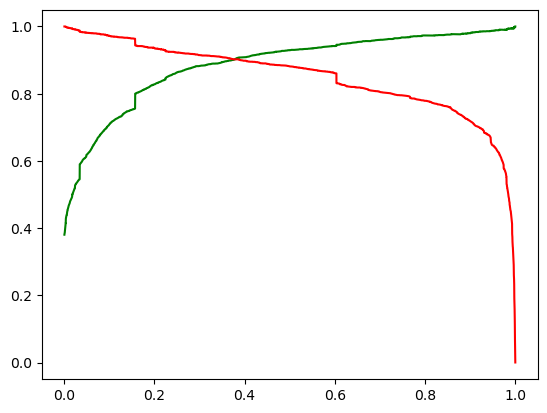

In [805]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [806]:
X_test[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']])

TotalVisits  Total Time Spent on Website  Page Views Per Visit
8970    -1.207883                    -0.573743             -1.264586
8280    -0.832700                    -0.248405             -0.642469
6941    -0.832700                    -1.035871             -1.264586
7343     4.795049                     0.017781             -0.561593
3734    -0.082334                    -0.595925              0.601766

In [807]:
X_test_lm = X_test[feature_select]

In [808]:
X_test_sm = sm.add_constant(X_test_lm)

In [809]:
feature_select

Index(['Total Time Spent on Website', 'Lead Origin_Landing Page Submission',
       'Lead Source_Others', 'Lead Source_Reference',
       'Lead Source_Welingak Website', 'Last Activity_SMS Sent',
       'What is your current occupation_Working Professional',
       'Tags_Closed by Horizzon', 'Tags_Interested in other courses',
       'Tags_Lost to EINS', 'Tags_Other_Tags', 'Tags_Ringing',
       'Tags_Will revert after reading the email',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation'],
      dtype='object')

In [810]:
y_test_pred = res.predict(X_test_sm)

In [811]:
y_test_pred[:10]

7681    0.028828
984     0.012538
8135    0.721542
6915    0.002672
2712    0.964481
244     0.003457
4698    0.006376
8287    0.034224
6791    0.987155
8970    0.006307
dtype: float64

In [812]:
y_pred_1 = pd.DataFrame(y_test_pred)

In [813]:
# Let's see the head
y_pred_1.head()

0
7681  0.028828
984   0.012538
8135  0.721542
6915  0.002672
2712  0.964481

In [814]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [815]:
# Putting CustID to index
y_test_df['CustID'] = y_test_df.index

In [816]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [817]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [818]:
y_pred_final.head()

Converted  CustID         0
0          0    7681  0.028828
1          0     984  0.012538
2          0    8135  0.721542
3          0    6915  0.002672
4          1    2712  0.964481

In [819]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

In [820]:
y_pred_final.head()

Converted  CustID  Converted_Prob
0          0    7681        0.028828
1          0     984        0.012538
2          0    8135        0.721542
3          0    6915        0.002672
4          1    2712        0.964481

In [821]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.4 else 0)

In [822]:
y_pred_final.head()

Converted  CustID  Converted_Prob  final_predicted
0          0    7681        0.028828                0
1          0     984        0.012538                0
2          0    8135        0.721542                1
3          0    6915        0.002672                0
4          1    2712        0.964481                1

In [823]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.9285182427401341

In [824]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1585,   91],
       [ 101,  909]])

In [825]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [826]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9

In [827]:
# Let us calculate specificity
TN / float(TN+FP)

0.9457040572792362

In [828]:
# Calculate precision
TP/ float(TP+FP)

0.909